## Pre-Processing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

Experiment / Learn Regex

In [4]:
fn = df_train['review'][0]; fn

'Ga disappointed neat products .. Meletot Hilsnyaa Speed \u200b\u200bof delivery is good.'

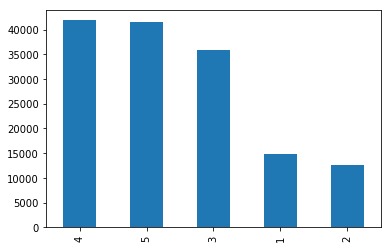

In [5]:
df_train['rating'].value_counts().plot.bar()

In [6]:
import re
re.findall(r' [^/]',fn)

[' d', ' n', ' p', ' .', ' M', ' H', ' S', ' \u200b', ' d', ' i', ' g']

## Model

In [7]:
import torch
#import torchtext
#from torchtext.datasets import text_classification
NGRAMS = 2

BATCH_SIZE = 16
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

<b>Define the Model

In [8]:
import torch.nn as nn
import torch.nn.functional as F
class TextSentiment(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super().__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

In [9]:
VOCAB_SIZE = len(df_train['review'].get_vocab())
EMBED_DIM = 32
NUN_CLASS = len(df_train['rating'].unique())
model = TextSentiment(VOCAB_SIZE, EMBED_DIM, NUN_CLASS).to(device)

AttributeError: 'Series' object has no attribute 'get_vocab'

<b> Generate Batch

In [10]:
def generate_batch(batch):
    label = torch.tensor([entry[0] for entry in batch])
    text = [entry[1] for entry in batch]
    offsets = [0] + [len(entry) for entry in text]
    # torch.Tensor.cumsum returns the cumulative sum
    # of elements in the dimension dim.
    # torch.Tensor([1.0, 2.0, 3.0]).cumsum(dim=0)

    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text = torch.cat(text)
    return text, offsets, label

<b> Train the model

In [11]:
from torch.utils.data import DataLoader

def train_func(sub_train_):

    # Train the model
    train_loss = 0
    train_acc = 0
    data = DataLoader(sub_train_, batch_size=BATCH_SIZE, shuffle=True,
                      collate_fn=generate_batch)
    for i, (text, offsets, cls) in enumerate(data):
        optimizer.zero_grad()
        text, offsets, cls = text.to(device), offsets.to(device), cls.to(device)
        output = model(text, offsets)
        loss = criterion(output, cls)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        train_acc += (output.argmax(1) == cls).sum().item()

    # Adjust the learning rate
    scheduler.step()

    return train_loss / len(sub_train_), train_acc / len(sub_train_)

def test(data_):
    loss = 0
    acc = 0
    data = DataLoader(data_, batch_size=BATCH_SIZE, collate_fn=generate_batch)
    for text, offsets, cls in data:
        text, offsets, cls = text.to(device), offsets.to(device), cls.to(device)
        with torch.no_grad():
            output = model(text, offsets)
            loss = criterion(output, cls)
            loss += loss.item()
            acc += (output.argmax(1) == cls).sum().item()

    return loss / len(data_), acc / len(data_)

In [12]:
import time
from torch.utils.data.dataset import random_split
N_EPOCHS = 20
min_valid_loss = float('inf')

criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=4.0)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.9)

train_len = int(len(train_dataset) * 0.95)
sub_train_, sub_valid_ = \
    random_split(train_dataset, [train_len, len(train_dataset) - train_len])

for epoch in range(N_EPOCHS):

    start_time = time.time()
    train_loss, train_acc = train_func(sub_train_)
    valid_loss, valid_acc = test(sub_valid_)

    secs = int(time.time() - start_time)
    mins = secs / 60
    secs = secs % 60

    print('Epoch: %d' %(epoch + 1), " | time in %d minutes, %d seconds" %(mins, secs))
    print(f'\tLoss: {train_loss:.4f}(train)\t|\tAcc: {train_acc * 100:.1f}%(train)')
    print(f'\tLoss: {valid_loss:.4f}(valid)\t|\tAcc: {valid_acc * 100:.1f}%(valid)')

NameError: name 'model' is not defined

## Model II

In [28]:
df_train.head()

,review_id,review,rating
0,0,Ga disappointed neat products .. Meletot Hilsn...,1
1,1,"Rdtanya replace broken glass, broken chargernya",1
2,2,Nyesel bngt dsni shopping antecedent photo mes...,1
3,3,Sent a light blue suit goods ga want a refund,1
4,4,Pendants came with dents and scratches on its ...,1


In [13]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torch
# Use cuda if present
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device available for running: ")
print(device)

Device available for running: 
cpu


Create Stemmed Tokens

In [14]:
from gensim.utils import simple_preprocess
# Tokenize the text column to get the new column 'tokenized_text'
df_train['tokenized_text'] = [simple_preprocess(line, deacc=True) for line in df_train['review']] 
df_test['tokenized_text'] = [simple_preprocess(line, deacc=True) for line in df_test['review']] 
print(df_train['tokenized_text'].head(10))

0    [ga, disappointed, neat, products, meletot, hi...
1    [rdtanya, replace, broken, glass, broken, char...
2    [nyesel, bngt, dsni, shopping, antecedent, pho...
3    [sent, light, blue, suit, goods, ga, want, ref...
4    [pendants, came, with, dents, and, scratches, ...
5         [dg, yg, depending, being, sent, in, photos]
6                               [hours, not, hologram]
7    [shop, fraudulent, business, we, put, two, lam...
8                         [well, according, to, price]
9    [pictures, and, names, of, elise, but, the, br...
Name: tokenized_text, dtype: object


In [15]:
from gensim.parsing.porter import PorterStemmer
porter_stemmer = PorterStemmer()

# Get the stemmed_tokens
df_train['stemmed_tokens'] = [[porter_stemmer.stem(word) for word in tokens] for tokens in df_train[
    'tokenized_text'] ]
df_test['stemmed_tokens'] = [[porter_stemmer.stem(word) for word in tokens] for tokens in df_test[
    'tokenized_text'] ]
df_train['stemmed_tokens'].head(10)

0    [ga, disappoint, neat, product, meletot, hilsn...
1    [rdtanya, replac, broken, glass, broken, charg...
2    [nyesel, bngt, dsni, shop, anteced, photo, mes...
3    [sent, light, blue, suit, good, ga, want, refund]
4    [pendant, came, with, dent, and, scratch, on, ...
5                [dg, yg, depend, be, sent, in, photo]
6                                [hour, not, hologram]
7    [shop, fraudul, busi, we, put, two, lamp, on, ...
8                            [well, accord, to, price]
9    [pictur, and, name, of, elis, but, the, brand,...
Name: stemmed_tokens, dtype: object

<b>Model</b>

In [16]:
from gensim.models import Word2Vec
import os
size = 500
window = 3
min_count = 1
workers = 3
sg = 1
OUTPUT_FOLDER = os.getcwd()
# Function to train word2vec model
def make_word2vec_model(top_data_df_small, padding=True, sg=1, min_count=1, size=500, workers=3, window=3):
    if  padding:
        print(len(top_data_df_small))
        temp_df = pd.Series(top_data_df_small['stemmed_tokens']).values
        temp_df = list(temp_df)
        temp_df.append(['pad'])
        word2vec_file = OUTPUT_FOLDER + '/models/' + 'word2vec_' + str(size) + '_PAD.model'
    else:
        temp_df = top_data_df_small['stemmed_tokens']
        word2vec_file = OUTPUT_FOLDER + '/models/' + 'word2vec_' + str(size) + '.model'
    w2v_model = Word2Vec(temp_df, min_count = min_count, size = size, 
                         workers = workers, window = window, sg = sg)

    w2v_model.save(word2vec_file)
    return w2v_model, word2vec_file

# Train Word2vec model
w2vmodel, word2vec_file = make_word2vec_model(
    df_train, padding=True, sg=sg, 
    min_count=min_count, size=size, workers=workers, window=window)

146811


Generate Input Tensor from Word2Vec Model

In [17]:
max_sen_len = df_train.stemmed_tokens.map(len).max()
padding_idx = w2vmodel.wv.vocab['pad'].index
def make_word2vec_vector_cnn(sentence):
    padded_X = [padding_idx for i in range(max_sen_len)]
    i = 0
    for word in sentence:
        if word not in w2vmodel.wv.vocab:
            padded_X[i] = 0
            print(word)
        else:
            padded_X[i] = w2vmodel.wv.vocab[word].index
        i += 1
    return torch.tensor(padded_X, dtype=torch.long, device=device).view(1, -1)

<b>Final Model

In [18]:
import os
EMBEDDING_SIZE = 500
NUM_FILTERS = 10
OUTPUT_FOLDER = os.getcwd()
import gensim

class CnnTextClassifier(nn.Module):
    def __init__(self, vocab_size, num_classes, window_sizes=(1,2,3,5)):
        super(CnnTextClassifier, self).__init__()
        w2vmodel = gensim.models.KeyedVectors.load(OUTPUT_FOLDER + '/models/' + 'word2vec_500_PAD.model')
        weights = w2vmodel.wv
        # With pretrained embeddings
        self.embedding = nn.Embedding.from_pretrained(
            torch.FloatTensor(weights.vectors), padding_idx=w2vmodel.wv.vocab['pad'].index)
        # Without pretrained embeddings
        # self.embedding = nn.Embedding(vocab_size, EMBEDDING_SIZE)

        self.convs = nn.ModuleList([
                                   nn.Conv2d(1, NUM_FILTERS, [window_size, EMBEDDING_SIZE], padding=(window_size - 1, 0))
                                   for window_size in window_sizes
        ])

        self.fc = nn.Linear(NUM_FILTERS * len(window_sizes), num_classes)

    def forward(self, x):
        x = self.embedding(x) # [B, T, E]

        # Apply a convolution + max_pool layer for each window size
        x = torch.unsqueeze(x, 1)
        xs = []
        for conv in self.convs:
            x2 = torch.tanh(conv(x))
            x2 = torch.squeeze(x2, -1)
            x2 = F.max_pool1d(x2, x2.size(2))
            xs.append(x2)
        x = torch.cat(xs, 2)

        # FC
        x = x.view(x.size(0), -1)
        logits = self.fc(x)

        probs = F.softmax(logits, dim = 1)

        return probs

In [19]:
len(df_train)

146811

In [65]:
x_train = df_train.sample(60000).reset_index(drop=True)

In [66]:
x_train['rating'].value_counts()

4    17245
5    16921
3    14591
1     6104
2     5139
Name: rating, dtype: int64

In [67]:
x_train['rating']-=1

In [68]:
NUM_CLASSES = 5
VOCAB_SIZE = len(w2vmodel.wv.vocab)

cnn_model = CnnTextClassifier(vocab_size=VOCAB_SIZE, num_classes=NUM_CLASSES)
cnn_model.to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.0005)
num_epochs = 30

# Open the file for writing loss
loss_file_name = OUTPUT_FOLDER +  '/plots/' + 'cnn_class_big_loss_with_padding.csv'
f = open(loss_file_name,'w')
f.write('iter, loss')
f.write('\n')
losses = []

cnn_model.train()

for epoch in range(num_epochs):
    print("Epoch" + str(epoch + 1))
    train_loss = 0
    for index, row in x_train.iterrows():
        # Clearing the accumulated gradients
        cnn_model.zero_grad()

        # Make the bag of words vector for stemmed tokens 
        bow_vec = make_word2vec_vector_cnn(row['stemmed_tokens'])
       
        # Forward pass to get output
        probs = cnn_model(bow_vec)

        # Get the target label
        target = torch.tensor([x_train['rating'][index]], dtype=torch.long, device=device)

        # Calculate Loss: softmax --> cross entropy loss
        loss = loss_function(probs, target)
        train_loss += loss.item()

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()


    # if index == 0:
    #     continue
    print("Epoch ran :"+ str(epoch+1))
    print("Loss: ", train_loss / len(x_train))
    f.write(str((epoch+1)) + "," + str(train_loss / len(x_train)))
    f.write('\n')
    train_loss = 0

torch.save(cnn_model, OUTPUT_FOLDER + 'cnn_big_model_500_with_padding.pth')

f.close()
print("Input vector")
print(bow_vec.cpu().numpy())
print("Probs")
print(probs)
print(torch.argmax(probs, dim=1).cpu().numpy()[0])

Epoch1
Epoch ran :1
Loss:  1.4251429146120946
Epoch2
Epoch ran :2
Loss:  1.3981582073162
Epoch3
Epoch ran :3
Loss:  1.386680153160294
Epoch4
Epoch ran :4
Loss:  1.3816342472602923
Epoch5
Epoch ran :5
Loss:  1.3766854188203812
Epoch6
Epoch ran :6
Loss:  1.3740474690039952
Epoch7
Epoch ran :7
Loss:  1.3717914553145567
Epoch8
Epoch ran :8
Loss:  1.3701117288947104
Epoch9
Epoch ran :9
Loss:  1.3668044335732858
Epoch10
Epoch ran :10
Loss:  1.3656896329532067
Epoch11
Epoch ran :11
Loss:  1.3641304861426353
Epoch12
Epoch ran :12
Loss:  1.3611096591671308
Epoch13
Epoch ran :13
Loss:  1.3610544036060572
Epoch14
Epoch ran :14
Loss:  1.3585616721888383
Epoch15
Epoch ran :15
Loss:  1.3570957308202982
Epoch16
Epoch ran :16
Loss:  1.355223041133086
Epoch17
Epoch ran :17
Loss:  1.3539381322344144
Epoch18
Epoch ran :18
Loss:  1.3512554753442605
Epoch19
Epoch ran :19
Loss:  1.350452806179722
Epoch20
Epoch ran :20
Loss:  1.348244550910592
Epoch21
Epoch ran :21
Loss:  1.347198249000311
Epoch22
Epoch ran 

C:\Users\yu.an\AppData\Local\Continuum\anaconda3\envs\dl\lib\site-packages\torch\serialization.py:402: UserWarning: Couldn't retrieve source code for container of type CnnTextClassifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


RuntimeError: Can't call numpy() on Variable that requires grad. Use var.detach().numpy() instead.

Accuracy

In [69]:
acc_test = True

if acc_test:
    x_test = df_train[~df_train['review_id'].isin(x_train['review_id'])].sample(1000)
else:
    x_test = df_test

Index(['iter', ' loss'], dtype='object')


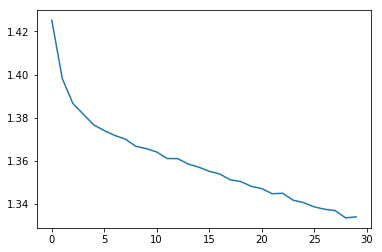

In [70]:
from sklearn.metrics import classification_report
bow_cnn_predictions = []
original_lables_cnn_bow = []
cnn_model.eval()
loss_df = pd.read_csv(OUTPUT_FOLDER + '/plots/cnn_class_big_loss_with_padding.csv')
print(loss_df.columns)
# loss_df.plot('loss')
with torch.no_grad():
    for index, row in x_test.iterrows():
        bow_vec = make_word2vec_vector_cnn(row['stemmed_tokens'])
        probs = cnn_model(bow_vec)
        _, predicted = torch.max(probs.data, 1)
        bow_cnn_predictions.append(predicted.cpu().numpy()[0])
        
        x_test.loc[index,'preds'] = int(predicted.cpu().numpy()[0])
        if acc_test:
            original_lables_cnn_bow.append(x_test['rating'][index])
        
#print(classification_report(original_lables_cnn_bow,bow_cnn_predictions))
loss_file_name = OUTPUT_FOLDER +  '/plots/' + 'cnn_class_big_loss_with_padding.csv'
loss_df = pd.read_csv(loss_file_name)
#print(loss_df.columns)
plt_500_padding_30_epochs = loss_df[' loss'].plot()
fig = plt_500_padding_30_epochs.get_figure()
fig.savefig(OUTPUT_FOLDER +'/plots/' + 'loss_plt_500_padding_30_epochs.pdf')

In [71]:
x_test['preds']+=1
if acc_test:
    print(sum(x_test['preds']==x_test['rating'])/len(x_test))

0.485


Run Model

Index(['iter', ' loss'], dtype='object')
klihtan
delier
brook
prodct
laria
unfortn
prodct
thamx
corresond
mamuaskan
lapakku
stanard
rpm
limber
responsbl
kesalan
namaj
vaj
reseect
fllthei
custboada
trimakaish
tenni
pengirminnya
disappint
ditainya
ittttt
yestrdai
cumulu
baaaaiikkk
substati
squeak
duniaunik
makashhhhh
themveri
stanard
kmm
kmmmm
pmmmm
hargalh
kekiniannya
normallyi
traction
ngejadiin
shipent
contnt
sligtli
direkom
lipglo
pantslah
accod
epikk
mateial
akasi
gemashhhh
timidli
cale
pengennnn
puma
plak
fcjtul
aggress
frequntli
bahannuya
cushioni
laanf
stanard
consier
umptenth
averi
communi
fasi
nutriplu
lightest
realflex
sjsnksosxi
bsjjzh
sbd
jso
sjsozh
sjg
hzggj
jshjk
kzjjk
everyh
fabuou
proprli
expet
socilli
teceiv
sukkkaaaa
suitbl
substnc
kurik
sinisend
tenni
servc
passbl
quickbut
dpej
gowalk
bellagionya
paperbag
friedli
chuu
chuu
ditepuk
chope
trimaasih
inexpns
paydai
marchemod
gsg
wella
hopeulli
fibroblast
stylishord
gmz
bngetss
dbntuu
sukat
katawan
jalseul
shouder
ticker
m

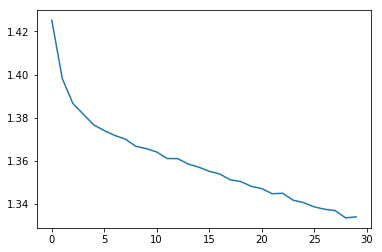

In [72]:
acc_test=False
x_test = df_test.copy()

from sklearn.metrics import classification_report
bow_cnn_predictions = []
original_lables_cnn_bow = []
cnn_model.eval()
loss_df = pd.read_csv(OUTPUT_FOLDER + '/plots/cnn_class_big_loss_with_padding.csv')
print(loss_df.columns)
# loss_df.plot('loss')
with torch.no_grad():
    for index, row in x_test.iterrows():
        bow_vec = make_word2vec_vector_cnn(row['stemmed_tokens'])
        probs = cnn_model(bow_vec)
        _, predicted = torch.max(probs.data, 1)
        bow_cnn_predictions.append(predicted.cpu().numpy()[0])
        
        x_test.loc[index,'preds'] = int(predicted.cpu().numpy()[0])
        if acc_test:
            original_lables_cnn_bow.append(x_test['rating'][index])
        
#print(classification_report(original_lables_cnn_bow,bow_cnn_predictions))
loss_file_name = OUTPUT_FOLDER +  '/plots/' + 'cnn_class_big_loss_with_padding.csv'
loss_df = pd.read_csv(loss_file_name)
#print(loss_df.columns)
plt_500_padding_30_epochs = loss_df[' loss'].plot()
fig = plt_500_padding_30_epochs.get_figure()
fig.savefig(OUTPUT_FOLDER +'/plots/' + 'loss_plt_500_padding_30_epochs.pdf')

In [86]:
x_test['rating'].value_counts()

4    26376
3    13515
5    10343
1     8071
2     2122
Name: rating, dtype: int64

In [84]:
x_test['rating']+=1

In [80]:
x_test['preds'] = x_test['preds'].astype(int)

x_test.rename(columns={'preds':'rating'},inplace=True)

In [87]:
x_test[['review_id','rating']].to_csv('practice4.csv',index=False)